In [12]:
import pandas as pd
from bertopic import BERTopic
from sklearn.model_selection import train_test_split
from bertopic.vectorizers import ClassTfidfTransformer
from bertopic.dimensionality import BaseDimensionalityReduction
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import classification_report

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier

# Preporcessing



In [13]:
merged_dataframe = pd.read_csv('merged_dataframe.csv')
merged_sentences = pd.read_csv('merged_sentences.csv')
merged_dataframe

,annotation_category,annotation,entity,sentence,entity_atomized,sentiment,tsc_sentiment,blame,praise
0,blame,"new arms deliveries to Kiev are aimed at ""prol...",US,Speaking to the Rossiya-1 state television cha...,US,-1,0,1,0
1,blame,has been sending more advanced and heavier wea...,US,"From the beginning, the US has been sending mo...",US,-1,0,1,0
2,blame,clearly knows that a prolonged conflict betwee...,US,The US clearly knows that a prolonged conflict...,US,1,0,1,0
3,blame,has put its national interests into considerat...,US,The US has put its national interests into con...,US,1,0,1,0
4,blame,"With self-interests in mind, the US will not s...",US,"With self-interests in mind, the US will not s...",US,-1,0,1,0
...,...,...,...,...,...,...,...,...,...
406,blame,"US inflation will become higher, ordinary peop...",If the US does prohibit oil exports to China,The US only has itself to blame for the curren...,US,-1,0,1,0
407,blame,"US inflation will become higher, ordinary peop...",If the US does prohibit oil exports to China,The US only has itself to blame for the curren...,China,-1,-1,1,0
408,blame,"would undermine US oil companies, and they wil...",Prohibiting the export of oil and petroleum pr...,Prohibiting the export of oil and petroleum pr...,US,-1,0,1,0
409,blame,"would undermine US oil companies, and they wil...",Prohibiting the export of oil and petroleum pr...,Prohibiting the export of oil and petroleum pr...,China,-1,-1,1,0


In [14]:
#drop duplicates
#merged_dataframe = merged_dataframe.drop_duplicates(subset= ['sentence', 'annotation_category'])
merged_dataframe = merged_dataframe.sample(frac=1).reset_index(drop=True)
merged_dataframe

,annotation_category,annotation,entity,sentence,entity_atomized,sentiment,tsc_sentiment,blame,praise
0,blame,has inflated food commodity prices that were a...,the conflict in Ukraine,"""In a May 4 report, the World Food Programme s...",Ukraine,-1,0,1,0
1,praise,will make its products the best choice for man...,China's low inflation,"It is still the world's manufacturing basis,"" ...",China,1,0,0,1
2,blame,under the pretext of security will be of no he...,Japan and NATO,This kind of collusion between Japan and NATO ...,Japan,-1,0,1,0
3,blame,the arms the US and NATO donated are being sol...,US and NATO,ASB Military News reported on June 2 that some...,NATO,0,0,1,0
4,blame,"Tunisia's inflation, which has already been ex...","conflict between Russia and Ukraine,","As a net importer of food and energy, Tunisia'...",Ukraine,-1,0,1,0
...,...,...,...,...,...,...,...,...,...
406,blame,has already turned the Middle East and Europe ...,US,"""The US has already turned the Middle East and...",US,-1,-1,1,0
407,blame,using the current Russia-Ukraine crisis to hyp...,US,Japan is the one that closely follows the US i...,US,-1,0,1,0
408,blame,have chosen to follow the US to attack China o...,Japan and Australia,Only states like Japan and Australia have chos...,Japan,1,1,1,0
409,blame,will further precipitate the risk of capital o...,rate hikes in developed countries,So rate hikes in developed countries will furt...,rate hikes in developed countries,-1,-1,1,0


# EDA

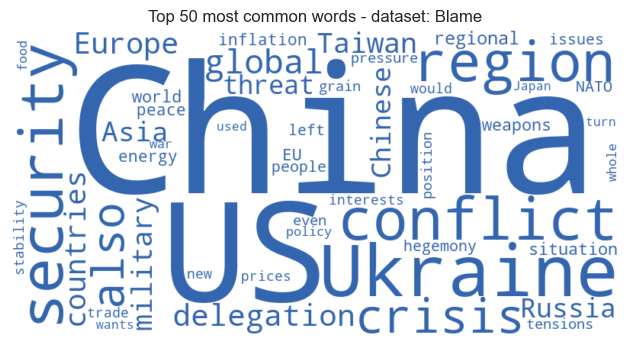

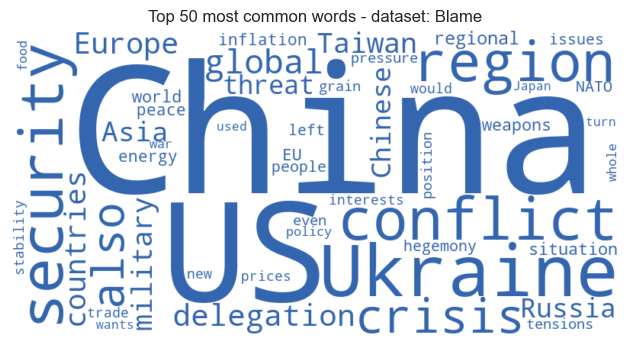

In [15]:
from Preparations.EDA_script import plot_top_N_common_words
df_eda = merged_dataframe
df_eda['article_text'] = merged_dataframe['annotation']
#dilter only blame
blame_plt = plot_top_N_common_words(df_eda[df_eda['annotation_category'] == 'blame'],"Blame", 50)
blame_plt

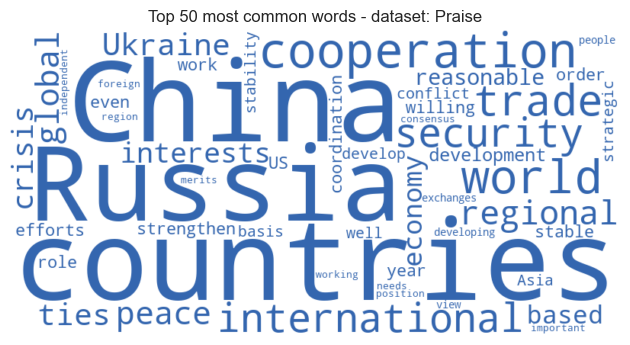

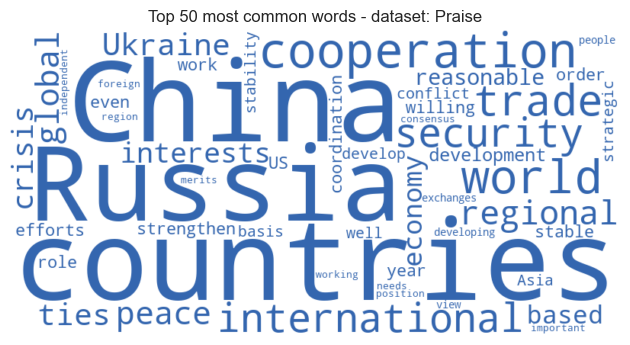

In [4]:
praise_plt= plot_top_N_common_words(df_eda[df_eda['annotation_category'] == 'praise'],"Praise", 50)
praise_plt

In [16]:
import plotly.express as px
import pandas as pd
from colors import my_red, my_green, my_yellow

# Count how many times each atomized entity was blamed or praised
merged_dataframe = merged_dataframe[merged_dataframe['annotation_category'] != "event"]
entity_blame_praise_counts = merged_dataframe.groupby(['entity_atomized', 'annotation_category']).size().unstack(fill_value=0)

# Adjust the counts: make praise positive and blame negative
entity_blame_praise_counts['blame'] = -entity_blame_praise_counts['blame']

# Get the top 15 most common atomized entities by their total absolute counts
top_15_entities = entity_blame_praise_counts.abs().sum(axis=1).nlargest(15).index

# Filter the DataFrame to keep only the top 15
entity_blame_praise_counts_top_15 = entity_blame_praise_counts.loc[top_15_entities].reset_index()
entity_blame_praise_counts_top_15 = entity_blame_praise_counts_top_15.melt(
    id_vars='entity_atomized',
    value_vars=['blame', 'praise'],
    var_name='Annotation Category',
    value_name='Count'
)

# Plot using Plotly with theme 'minimal'
fig = px.bar(
    entity_blame_praise_counts_top_15,
    x='Count',
    y='entity_atomized',
    color='Annotation Category',
    color_discrete_map={'blame': my_red, 'praise': my_green},
    text='Count',
    orientation='h',
    title='Count of blames (below 0) and praises (above 0) per entity (Top 15)',
    template='plotly_white',  # Plotly minimal theme
)

fig.update_traces(textposition='outside')
fig.update_layout(
    xaxis_title='Count',
    yaxis_title='Entity',
    legend_title_text='Annotation Category',
    bargap=0.2
)

fig.show()

In [17]:
import plotly.express as px

# Select relevant columns for correlation
correlation_data = merged_dataframe[['annotation_category', 'sentiment', 'tsc_sentiment']]
# Map annotation category to numerical values
correlation_data['annotation_category'] = correlation_data['annotation_category'].map({'blame': -1, 'praise': 1, 'event': 0})
#RENAME COLUMNS
correlation_data = correlation_data.rename(columns={'annotation_category': 'Blame/Praise', 'sentiment': 'Vader sentiment', 'tsc_sentiment': 'TSC sentiment'})
# Compute the correlation matrix
correlation_matrix = correlation_data.corr()

# Convert to long format for Plotly heatmap
correlation_matrix = correlation_matrix.reset_index().melt(id_vars='index', var_name='Variable', value_name='Correlation')

# Plot the correlation matrix using Plotly with a gradient from my_yellow to my_red
fig = px.imshow(
    correlation_data.corr(),
    text_auto=".2f",
    color_continuous_scale=[my_yellow, my_red],
    labels={ "color": "Correlation"},
    title='Correlation Matrix: Blame/Praise, Sentiment and TSC Sentiment',
    template="plotly_white"  # Plotly minimal theme
)

fig.update_layout(coloraxis_colorbar_title="Correlation")
fig.show()
#save the plot
fig.write_html("correlation_matrix.html")

In [18]:
#full dataset
full_df = merged_dataframe[['sentence', 'blame', 'praise', 'annotation_category']]
full_df = merged_sentences.merge(full_df, left_on='sentence', right_on='sentence', how='left')
full_df = full_df.fillna(0)
full_df['blame'] = full_df['blame'].astype(int)
full_df['praise'] = full_df['praise'].astype(int)
#map annotation category
full_df['annotation_category'] = full_df['annotation_category'].apply(lambda x: -1 if x == 'blame' else 1 if x =='praise' else 0)
full_df

,sentence,blame,praise,annotation_category
0,Speaking to the Rossiya-1 state television cha...,1,0,-1
1,"""Putin's remarks came a few days after US Pres...",0,0,0
2,"""Putin did not specify which targets he meant.",0,0,0
3,"Song Zhongping, a Beijing-based military exper...",0,0,0
4,"From the beginning, the US has been sending mo...",1,0,-1
...,...,...,...,...
12960,"That must be respected, as we would expect Chi...",0,0,0
12961,"Of course, one can have opinions on these things.",0,0,0
12962,One can even make criticisms if one wants.,0,0,0
12963,But they shouldn't interfere in state relation...,0,0,0


In [19]:
#balanced dataset
blame_df = full_df[full_df['annotation_category'] == -1]
praise_df = full_df[full_df['annotation_category'] == 1]
neutral_df = full_df[full_df['annotation_category'] == 0]
min_size = min(len(blame_df), len(praise_df))
max_size = max(len(blame_df), len(praise_df))

neutral_sampled = neutral_df.sample(max_size, random_state=42)

full_balanced_df = pd.concat([blame_df, praise_df, neutral_sampled], ignore_index=True)
full_balanced_df = full_balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)
#full_balanced_df = full_balanced_df.drop_duplicates(subset= ['sentence', 'annotation_category'])

#summarize the balanced dataset
print(f"Blame: {sum(full_balanced_df['annotation_category'] == -1)}")
print(f"Praise: {sum(full_balanced_df['annotation_category'] == 1)}")
print(f"Neutral: {sum(full_balanced_df['annotation_category'] == 0)}")
full_balanced_df


Blame: 296
Praise: 118
Neutral: 296


,sentence,blame,praise,annotation_category
0,Prohibiting the export of oil and petroleum pr...,1,0,-1
1,"""The Bucha incident is shrouded in mystery, th...",1,0,-1
2,Li also noted that the Chinese military will r...,0,0,0
3,"Japan has decided to hijack the whole region, ...",0,1,1
4,Ukraine is a huge tragedy and is sounding a hu...,1,0,-1
...,...,...,...,...
705,"""There is a good chance that Russia might cut ...",1,0,-1
706,Speaking during a US Senate Finance Committee ...,1,0,-1
707,Only states like Japan and Australia have chos...,1,0,-1
708,The stunt - US House Speaker Nancy Pelosi's vi...,0,0,0


In [20]:
#Train test split
y =  full_balanced_df['annotation_category']
docs = full_balanced_df['sentence']
X_train, X_test, y_train, y_test = train_test_split(docs, y, test_size=0.2, random_state=42)

# Modeling

In [21]:
#classifiers
classifiers = [
    LogisticRegression(),
    LinearDiscriminantAnalysis(),
    SVC(),
    DecisionTreeClassifier(),
    MLPClassifier(max_iter=10000),
]
classifiers_names = [
    'Logistic Regression',
    'Linear Discriminant Analysis',
    'Support Vector Classification',
    'Decision Tree Classifier',
    'MLP Classifier',
]

y_preds = []


In [20]:
for clf in tqdm(classifiers):
        empty_dimensionality_model = BaseDimensionalityReduction()
        ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)

        topic_model= BERTopic(
        umap_model=empty_dimensionality_model,
        hdbscan_model=clf,
        ctfidf_model=ctfidf_model
        )
        topics, probs = topic_model.fit_transform(list(X_train), y=list(y_train))
        y_predicted, probs_predicted  = topic_model.transform(list(X_test))
        y_preds.append(y_predicted)

100%|██████████| 5/5 [00:48<00:00,  9.75s/it]


In [17]:

print(f"Blame: {sum(x == -1 for x in y_predicted)}")
print(f"Praise: {sum(x == 1 for x in y_predicted)}")
print(f"Neutral: {sum(x == 0 for x in y_predicted)}")

Blame: 65
Praise: 22
Neutral: 55


In [20]:
for y_pred, clf_name in zip(y_preds, classifiers_names):
        cm = confusion_matrix(y_test, y_pred)
        accuracy = round(sum(y_test == y_pred) / len(y_test)*100, 2)

        # Plot the confusion matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Blame', 'Other', 'Praise'], yticklabels=['Blame', 'Other', 'Praise'])
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title(f'Confusion Matrix: {clf_name} \n Accuracy: {accuracy}%')
        plt.show()

# Fine tune SVC

In [148]:
from sklearn.model_selection import ParameterGrid
param_grid = {
    'kernel': ['poly'],
    'degree': [2, 3, 4, 5, 6],
}
grid = ParameterGrid(param_grid)

In [149]:
best_accuracy = 0
best_params = None
best_clf = None
for params in tqdm(grid):
    clf = SVC(**params)
    empty_dimensionality_model = BaseDimensionalityReduction()
    ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)

    topic_model= BERTopic(
    umap_model=empty_dimensionality_model,
    hdbscan_model=clf,
    ctfidf_model=ctfidf_model
    )
    topics, probs = topic_model.fit_transform(list(X_train), y=list(y_train))
    y_predicted, probs_predicted  = topic_model.transform(list(X_test))
    accuracy = round(sum(y_test == y_predicted) / len(y_test)*100, 2)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = params
        best_clf = clf
        print(f"Best accuracy: {best_accuracy}%")
        print(f"Best params: {best_params}")
        print(f"Best clf: {best_clf}")

 20%|██        | 1/5 [00:15<01:03, 15.79s/it]

Best accuracy: 83.1%
Best params: {'degree': 2, 'kernel': 'poly'}
Best clf: SVC(degree=2, kernel='poly')


100%|██████████| 5/5 [01:20<00:00, 16.05s/it]


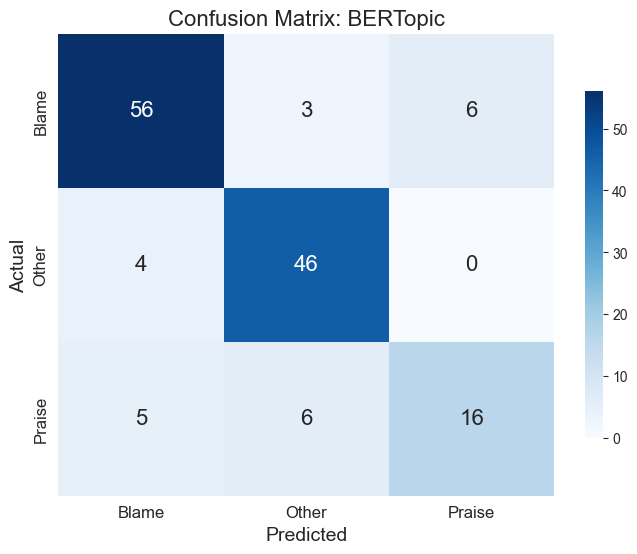

              precision    recall  f1-score   support

       Blame       0.86      0.86      0.86        65
       Other       0.84      0.92      0.88        50
      Praise       0.73      0.59      0.65        27

    accuracy                           0.83       142
   macro avg       0.81      0.79      0.80       142
weighted avg       0.83      0.83      0.83       142



In [29]:
clf = SVC()
empty_dimensionality_model = BaseDimensionalityReduction()
ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)

topic_model= BERTopic(
umap_model=empty_dimensionality_model,
hdbscan_model=clf,
ctfidf_model=ctfidf_model
)
topics, probs = topic_model.fit_transform(list(X_train), y=list(y_train))
y_predicted, probs_predicted  = topic_model.transform(list(X_test))

cm = confusion_matrix(y_test, y_predicted)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Blame', 'Other', 'Praise'],
            yticklabels=['Blame', 'Other', 'Praise'],
            cbar_kws={"shrink": 0.75},
            annot_kws={"size": 16})  # Make numbers in heatmap bigger
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('Actual', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title(f'Confusion Matrix: BERTopic', fontsize=16)
plt.show()

print(classification_report(y_test, y_predicted, target_names=['Blame', 'Other', 'Praise']))

In [23]:
for y_pred, clf_name in zip(y_preds, classifiers_names):
        cm = confusion_matrix(y_test, y_pred)
        accuracy = round(sum(y_test == y_pred) / len(y_test)*100, 2)

        # Plot the confusion matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Blame', 'Other', 'Praise'], yticklabels=['Blame', 'Other', 'Praise'])
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title(f'Confusion Matrix: {clf_name} \n Accuracy: {accuracy}%')
        plt.show()

        # Print classification report
        print(f'Classification Report for {clf_name}:\n')
        print(classification_report(y_test, y_pred, target_names=['Blame', 'Other', 'Praise']))



# FastText Embeddings + SVM Classifier

In [24]:
import fasttext.util
from sklearn.svm import SVC
from sklearn.metrics import classification_report

# Prepare the fasttext embeddings
fasttext.util.download_model('en', if_exists='ignore')  # Download English embeddings
print("Downloaded!")
ft = fasttext.load_model('cc.en.300.bin')  # Load the embeddings

# Generate embeddings for the sentences
def get_embeddings(sentences):
    return [ft.get_sentence_vector(sentence) for sentence in sentences]

Downloaded!


In [25]:
X_train_embeddings = get_embeddings(X_train)
X_test_embeddings = get_embeddings(X_test)

# Train a simple SVM classifier
svm = SVC()
svm.fit(X_train_embeddings, y_train)

# Predict and evaluate
y_pred = svm.predict(X_test_embeddings)
print(classification_report(y_test, y_pred, target_names=['Blame', 'Other', 'Praise']))

              precision    recall  f1-score   support

       Blame       0.68      0.94      0.79        65
       Other       0.69      0.68      0.69        50
      Praise       0.67      0.07      0.13        27

    accuracy                           0.68       142
   macro avg       0.68      0.56      0.54       142
weighted avg       0.68      0.68      0.63       142



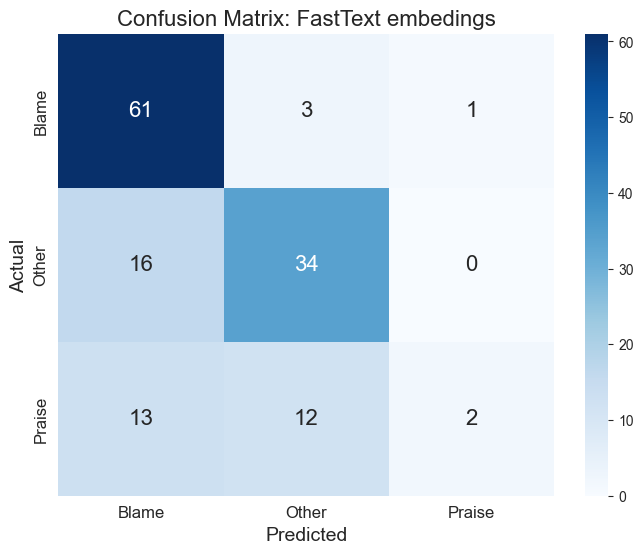

In [31]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Blame', 'Other', 'Praise'], yticklabels=['Blame', 'Other', 'Praise'], annot_kws={"size": 16})  # Make numbers in heatmap bigger
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('Actual', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title(f'Confusion Matrix: FastText embedings', fontsize=16)
plt.show()